In [1]:
import os, sys, re, datetime, shutil, copy, json
import numpy as np
import astropy.units as u
import astropy.constants as const
import matplotlib
from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict
from matplotlib import cm
from scipy.interpolate import griddata, interp1d, CubicSpline

def list2str(inlist, format_str = '{}'):
    return '[' + ', '.join([format_str.format(t) for t in inlist]) + ']'


In [6]:
# User-defined global parameters
# 'list_of_X_CICO_for_N_repISM' is determined from "calc_LTE_R_CI10CO21_varying_N_CO_T_kin.ipynb".

list_of_T_kin_for_N_repISM = [15., 20., 25., 50., 50., 100., 100.] # T_kin in K for repISM
#list_of_d_V_for_N_repISM = [3., 10., 25., 50., 40., 70., 90.] # d_V in km/s for repISM -- not needed here
#list_of_n_H2_for_N_repISM = 10**np.array([2.3, 2.4, 2.5, 3.0, 3.0, 3.0, 4.0]) # n_H2 in cm^-3 for repISM
list_of_n_H2_for_N_repISM = 10**np.array([2.5, 2.5, 2.5, 3.0, 3.0, 3.0, 3.0]) # n_H2 in cm^-3 for repISM
list_of_R_CI10CO21_for_N_repISM = [0.1, 0.1, 0.1, 0.2, 0.06, 0.1, 0.5]
list_of_X_COH2_for_N_repISM = [1e-4]*7
list_of_X_CICO_for_N_repISM = [0.2, 0.2, 0.3, 0.9, 0.2, 0.6, 2.0]
# list_of_highlight_Flux_Kkms_CO10_range_for_T_kin = [
#     (30.,50.), (100.,200.), (350.,500.), (800.,1000.), 
#     (700.,1000.), (1000.,1400.), (2000.,2200.) ] # K km s-1 for repISM -- not needed here

# list_of_I_CO_for_N_repISM = np.array([
#         np.mean(flux_pair) for flux_pair in \
#             list_of_highlight_Flux_Kkms_CO10_range_for_T_kin
#     ]) # -- not needed here

# The alphaCO alphaCI T-only functions are previously fitted by 
# "calc_LTE_alpha_CO_CI_new.ipynb" .
%run calc_LTE_alpha_CO_CI_new.ipynb

func_alphaCO10_T_only = lambda T_ex: \
    func_alpha_CO(T_ex, *CO10_T_only_popt)
    #(0.245354 + (T_ex/75)**(2.12119)) * ((T_ex/75)**(-1.5124)) -0.396845

func_alphaCO21_T_only = lambda T_ex: \
    func_alpha_CO(T_ex, *CO21_T_only_popt)
    #(0.0930983 + (T_ex/75)**(1.88482)) * ((T_ex/75)**(-2.02846)) -0.529101

func_alphaCI10_T_only = lambda T_ex: \
    func_alpha_CI(T_ex, *CI10_T_only_popt)
    #(0.0103232 + (T_ex/75)**(4.65158)) * ((T_ex/75)**(-3.6866)) +10.9302

# The NLCorr functions are previously fitted by: 
# "calc_NonLTE_RADEX_plot_alpha_{CO10,CO21,CI10}_correction_matrix.ipynb"

func_alphaCO10_T_NLCorr_curvefit = lambda T_kin, N_CO_d_V, n_H2: \
    func_alphaCO10_T_only(T_kin) \
    * 0.907422 / ( 1.0 - np.exp( - (np.log10(n_H2) / 1.81732)**(1.8733) ) ) \
    * ( N_CO_d_V / 1.94567e+17 )**( 1.0 - np.exp( -(92.6118 / T_kin)**(1.83199) ) )

func_alphaCO21_T_NLCorr_curvefit = lambda T_kin, N_CO_d_V, n_H2: \
    func_alphaCO21_T_only(T_kin) \
    * 4.85866 / ( 1.0 - np.exp( - (np.log10(n_H2) / 2.08223)**(2.05296) ) ) \
    * ( N_CO_d_V / 1.21396e+18 )**( 1.0 - np.exp( -(80.7532 / T_kin)**(0.401676) ) )

func_alphaCI10_T_NLCorr_curvefit = lambda T_kin, n_H2: \
    func_alphaCI10_T_only(T_kin) \
    * 0.998011 / ( 1.0 - np.exp( - ((np.log10(n_H2) - 1.27141 * np.log10(1.19667/T_kin)) / 4.31057)**(6.74671) ) )

# Note: converting I_CO to N_H2: N_H2 = 0.624e20 * alphaCO * I_CO, no Helium.

out_figure_name = 'Plot_NLCorr_alphaCO_alphaCO_RCICO_N_CO_d_V'


list_of_alphaCO10_for_N_repISM [2.574, 1.471, 0.692, 0.654, 0.753, 0.573, 0.525]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_N_CO_for_N_repISM [6.424e+17, 1.376e+18, 1.835e+18, 3.671e+18, 3.996e+18, 4.292e+18, 6.882e+18]
list_of_N_CI_for_N_repISM [1.285e+17, 2.753e+17, 3.671e+17, 7.341e+17, 7.992e+17, 8.584e+17, 1.376e+18]
list_of_N_CO_d_V_for_N_repISM [2.141e+17, 1.376e+17, 7.341e+16, 7.341e+16, 9.990e+16, 6.131e+16, 7.647e+16]
Loading 'out_LTE_alphaCO_alphaCI_new_QE_term_popt.json'
CO10_C_coeff = 0.019154525467252038 # s solMass / (K km pc2)
CO10_QE_popt = [0.32312165196336134, 2.4054068587888726, 1.118670066181087, 31.909970583244966, 2.0783370656061146]
CO21_C_coeff = 0.004791830144641124 # s solMass / (K km pc2)
CO21_QE_popt =

In [7]:
# Define function for NLCorr matrix interpolation only for CO


if __name__ == '__main__' and '__file__' not in globals():
    
    %run calc_NonLTE_RADEX_plot_R_CI10CO21_correction_matrix.ipynb
    # this includes def interpolate_NLCorr

def interpolate_NLCorr_alphaCO10(n_H2, N_CO_d_V, T_kin):
    return interpolate_NLCorr(n_H2, N_CO_d_V, T_kin, 'out_NLCorr_matrix_alphaCO10.fits')

def interpolate_NLCorr_alphaCO21(n_H2, N_CO_d_V, T_kin):
    return interpolate_NLCorr(n_H2, N_CO_d_V, T_kin, 'out_NLCorr_matrix_alphaCO21.fits')

def interpolate_NLCorr_alphaCI10(n_H2, N_CI_d_V, T_kin):
    return interpolate_NLCorr(n_H2, N_CI_d_V, T_kin, 'out_NLCorr_matrix_alphaCI10.fits')

def interpolate_NLCorr_alphaCI21(n_H2, N_CI_d_V, T_kin):
    return interpolate_NLCorr(n_H2, N_CI_d_V, T_kin, 'out_NLCorr_matrix_alphaCI21.fits')

func_alphaCO10_T_NLCorr_matrix = lambda T_kin, N_CO_d_V, n_H2: func_alphaCO10_T_only(T_kin) \
                                        * interpolate_NLCorr_alphaCO10(n_H2, N_CO_d_V, T_kin)

func_alphaCO21_T_NLCorr_matrix = lambda T_kin, N_CO_d_V, n_H2: func_alphaCO21_T_only(T_kin) \
                                        * interpolate_NLCorr_alphaCO21(n_H2, N_CO_d_V, T_kin)

func_alphaCI10_T_NLCorr_matrix = lambda T_kin, N_CO_d_V, X_CICO, n_H2: func_alphaCI10_T_only(T_kin) \
                                        * interpolate_NLCorr_alphaCI10(n_H2, N_CO_d_V*X_CICO, T_kin)

func_alphaCI21_T_NLCorr_matrix = lambda T_kin, N_CO_d_V, X_CICO, n_H2: func_alphaCI21_T_only(T_kin) \
                                        * interpolate_NLCorr_alphaCI21(n_H2, N_CO_d_V*X_CICO, T_kin)

# check alphaCO21 at a specific (T_kin, N_CO_d_V, n_H2)
print('func_alphaCO21_T_NLCorr_curvefit(15, 2e16, 300.)', 
      func_alphaCO21_T_NLCorr_curvefit(15, 2e16, 300.))
print('func_alphaCO21_T_NLCorr_matrix(15, 2e16, 300.)', 
      func_alphaCO21_T_NLCorr_matrix(15, 2e16, 300.))


func_alphaCO21_T_NLCorr_curvefit(15, 2e16, 300.) 0.5924864573893581
func_alphaCO21_T_NLCorr_matrix(15, 2e16, 300.) 1.1040607346519768


repISM 1 : alphaCO10^NoHeLTE = 2.78, NLTE = 3.11 (w/He 4.23), NCO/Dv = 2.00e+17
repISM 2 : alphaCO10^NoHeLTE = 1.86, NLTE = 2.16 (w/He 2.93), NCO/Dv = 1.78e+17
repISM 3 : alphaCO10^NoHeLTE = 1.41, NLTE = 0.98 (w/He 1.33), NCO/Dv = 7.94e+16
repISM 4 : alphaCO10^NoHeLTE = 0.84, NLTE = 0.47 (w/He 0.64), NCO/Dv = 7.08e+16
repISM 5 : alphaCO10^NoHeLTE = 0.84, NLTE = 0.58 (w/He 0.78), NCO/Dv = 1.00e+17
repISM 6 : alphaCO10^NoHeLTE = 0.95, NLTE = 0.36 (w/He 0.50), NCO/Dv = 6.31e+16
doing scaling using grid_R_CI10CO21_calc[0, :]
repISM 7 : alphaCO10^NoHeLTE = 0.95, NLTE = 0.44 (w/He 0.59), NCO/Dv = 8.91e+16
Output to 'Plot_NLCorr_alphaCO_alphaCO_RCICO_N_CO_d_V.pdf'


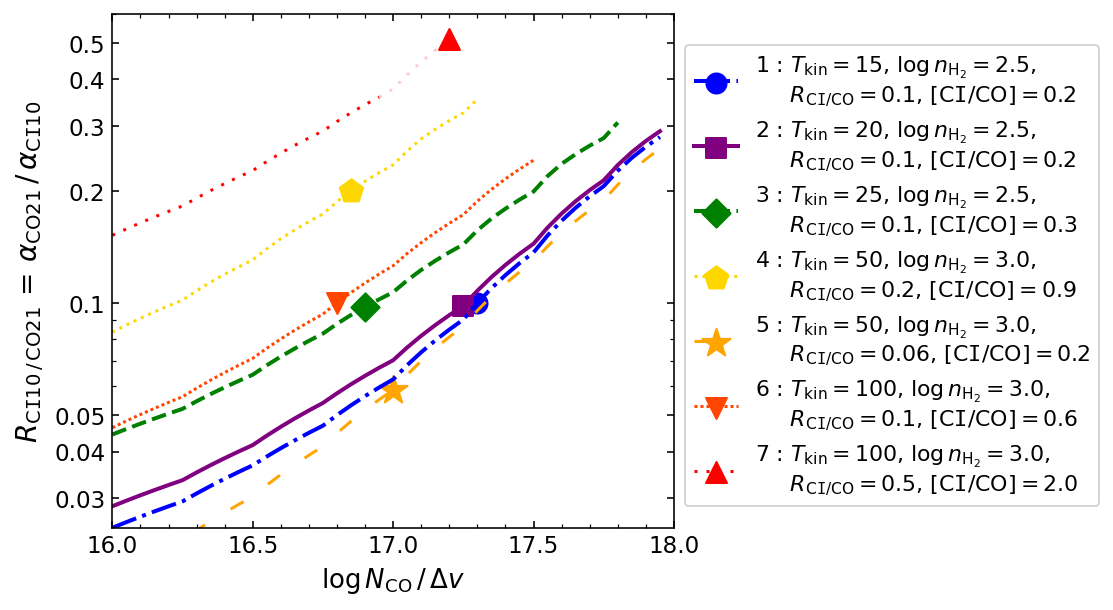

In [22]:
# Compute alphaCO alphaCI in a grid of N_CO_d_V then plot them
# Here we use accurate interpolation of NLCorr

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 11.5
matplotlib.rcParams['ytick.labelsize'] = 11.5
matplotlib.rcParams['axes.labelsize'] = 13.0
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['axes.formatter.useoffset'] = False
#matplotlib.rcParams['mathtext.fontset'] = 'custom'
#matplotlib.rcParams['mathtext.cal'] = 'stix:italic'
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import ticker
import matplotlib.patheffects as path_effects

list_of_linecolor_for_N_repISM = ['blue', 'purple', 'green', 
                                  'gold', 
                                  'orange', 'orangered', 'red'] 
                                  # [colormapper.to_rgba(np.log10(t)) for t in global_list_of_N_CO]
list_of_linestyle_for_N_repISM = ['dashdot', 'solid', 'dashed', 
                                  'dotted', 
                                  {'loosely dashed': (0, (5, 10))}, 
                                  {'dotted': (0, (1, 1))}, 
                                  {'dotted': (0, (1, 3))}]
list_of_linethick_for_N_repISM = [2.0, 2.0, 2.0, 
                                  1.5, 1.5, 1.5, 1.5]
list_of_linelabel_for_N_repISM = [None, None, None, 
                                  None, None, None, None]
list_of_marker_for_N_repISM = ['o', 's', 'D', 'p', '*', 'v', '^']

grid_N_CO_d_V = 10**np.arange(np.log10(1e17)-1.00, 
                              np.log10(1e17)+1.00+0.05, 
                              0.05)


fig = plt.figure(figsize=(7.8, 4.2))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r'$\log N_{\mathrm{CO}} \, / \, {\Delta v}$')
ax.set_ylabel(r'$R_{\mathrm{C}{\tt{I}}10 \, / \, \mathrm{CO21}} \, = ' + \
              r'\, \alpha_{\mathrm{CO}21} \, / \, \alpha_{\mathrm{C}{\tt{I}}10}$', fontsize=14)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, ), ))

grid_R_CI10CO21_calc = np.full([len(list_of_T_kin_for_N_repISM), len(grid_N_CO_d_V)], fill_value=np.nan)
grid_alphaCO10_calc = np.full([len(list_of_T_kin_for_N_repISM), len(grid_N_CO_d_V)], fill_value=np.nan)
grid_alphaCO10LTE_calc = np.full([len(list_of_T_kin_for_N_repISM), len(grid_N_CO_d_V)], fill_value=np.nan)

for i in range(len(grid_N_CO_d_V)):
    
    N_CO_d_V = grid_N_CO_d_V[i]
    
    list_of_alphaCO10LTE_for_N_repISM = np.array([
            (func_alphaCO10_T_only(t1) * (1e-4) / (t5)) \
            for t1,t5 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
            ))
        ])
    list_of_alphaCO10_for_N_repISM = np.array([
            (func_alphaCO10_T_NLCorr_matrix(t1, N_CO_d_V, t4) * (1e-4) / (t5)) \
            for t1,t4,t5 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
            ))
        ])
    list_of_alphaCO21_for_N_repISM = np.array([
            (func_alphaCO21_T_NLCorr_matrix(t1, N_CO_d_V, t4) * (1e-4) / (t5)) \
            for t1,t4,t5 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
            ))
        ])
    list_of_alphaCI10_for_N_repISM = np.array([
            (func_alphaCI10_T_NLCorr_matrix(t1, N_CO_d_V, t6, t4) * (1e-4 * 0.2) / (t5 * t6)) \
            for t1,t4,t5,t6 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
                list_of_X_CICO_for_N_repISM, 
            ))
        ])
    list_of_R_CI10CO21_calc = (\
            list_of_alphaCO21_for_N_repISM / \
            list_of_alphaCI10_for_N_repISM \
        )
    grid_R_CI10CO21_calc[:, i] = np.array(list_of_R_CI10CO21_calc)
    grid_alphaCO10_calc[:, i] = list_of_alphaCO10_for_N_repISM
    grid_alphaCO10LTE_calc[:, i] = list_of_alphaCO10LTE_for_N_repISM

plot_objects = []
plot_labels = []
for i in range(len(list_of_T_kin_for_N_repISM)):
    linestyle = list_of_linestyle_for_N_repISM[i]
    linethick = list_of_linethick_for_N_repISM[i]
    linecolor = list_of_linecolor_for_N_repISM[i]
    linelabel = list_of_linelabel_for_N_repISM[i]
    marker = list_of_marker_for_N_repISM[i]
    markersize = 100
    if marker == '*':
        markersize = int(markersize * 2.2)
    elif marker == 'p':
        markersize = int(markersize * 1.5)
    elif marker == 'v' or marker == '^':
        markersize = int(markersize * 1.1)
    if isinstance(linestyle, dict):
        linestyle = [linestyle[t] for t in linestyle][0]
    if linelabel is None or linelabel == '':
        linelabel = str((i+1)) + ' : ' + \
                    r'$T_{\mathrm{kin}} = ' + \
                    r'{:g}'.format(list_of_T_kin_for_N_repISM[i]) + \
                    r'$' + \
                    ', ' + \
                    r'$\log n_{\mathrm{H_2}} = ' + \
                    r'{:.1f}'.format(np.log10(list_of_n_H2_for_N_repISM[i])) + \
                    r'$' + \
                    ', \n     ' + \
                    r'$R_{\mathrm{C}{\tt{I}}/\mathrm{CO}} = ' + \
                    r'{:g}'.format(list_of_R_CI10CO21_for_N_repISM[i]) + \
                    r'$' + \
                    ', ' + \
                    r'$[\mathrm{C}{\tt{I}}/\mathrm{CO}] = ' + \
                    r'{:.1f}'.format(list_of_X_CICO_for_N_repISM[i]) + \
                    r'$'
    
    x = np.log10(grid_N_CO_d_V)
    y = grid_R_CI10CO21_calc[i, :]
    
    # find a point in the model line that matches the observed R_CI10CO21
    ix = np.nanargmin(np.abs(y - \
                             list_of_R_CI10CO21_for_N_repISM[i]))
    scatter_x = [np.log10(grid_N_CO_d_V[ix])]
    scatter_y = [grid_R_CI10CO21_calc[i, ix]]
    
    # plot the model line
    plot_obj1 = ax.plot(x, 
                y, 
                ls = linestyle, 
                lw = linethick, 
                color = linecolor, 
                label = linelabel, 
           )

    # check if the max of model line covers the observed R_CI10CO21 or not
    # if not, we need to do spline extrapolation
    mask = np.isfinite(y)
    if np.max(y[mask]) < list_of_R_CI10CO21_for_N_repISM[i]:
        #print('doing spline')
        #spline_x = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], num=100, endpoint=True)
        #spline_f = interp1d(x[mask], np.log10(y[mask]), 
        #                    fill_value='extrapolate', assume_sorted=True)
        #spline_y = 10**(spline_f(spline_x))
        # 
        print('doing scaling using grid_R_CI10CO21_calc[0, :]')
        spline_x = x
        spline_y = grid_R_CI10CO21_calc[0, :] / grid_R_CI10CO21_calc[0, ix] * grid_R_CI10CO21_calc[i, ix]
        # 
        ixx = np.nanargmin(np.abs(spline_y - \
                                 list_of_R_CI10CO21_for_N_repISM[i]))
        spline_mask = np.logical_and(spline_y >= np.max(y[mask]), 
                                     spline_y <= spline_y[ixx])
        plot_obj1x = ax.plot(spline_x[spline_mask], 
                    spline_y[spline_mask], 
                    ls = linestyle, 
                    lw = linethick, 
                    color = linecolor, 
                    label = '__none__', 
                    alpha = 0.2, 
               )
        scatter_x = spline_x[ixx]
        scatter_y = spline_y[ixx]
    
    # plot the scatter points on the model lines that match the observed R_CI10CO21
    plot_obj2 = ax.scatter(scatter_x, 
                scatter_y,
                marker = marker, 
                s = markersize, 
                color = linecolor, 
                label = '__none__'
            )
    
    ax.set_xlim([16.0, 18.0])
    ax.set_ylim([0.025, 0.6])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    
    plot_objects.append((plot_obj1[0], plot_obj2))
    plot_labels.append(linelabel)
    
    print('repISM {} : alphaCO10^NoHeLTE = {:.2f}, NLTE = {:.2f} (w/He {:.2f}), NCO/Dv = {:.2e}'.format(
        i+1, grid_alphaCO10LTE_calc[i, ix], 
        grid_alphaCO10_calc[i, ix], 
        grid_alphaCO10_calc[i, ix] * 1.36, 
        grid_N_CO_d_V[ix]))

ax.legend(plot_objects, plot_labels, fontsize=11., loc='center left', bbox_to_anchor=(1.0, 0.0, 0.5, 0.98))
#fig.tight_layout()
fig.subplots_adjust(left=0.10, right=0.60, bottom=0.12, top=0.97)
fig.savefig(out_figure_name + '.pdf', dpi=300)
print('Output to {!r}'.format(out_figure_name + '.pdf'))


repISM 1 : alphaCO10^NoHe = 2.75 (w/He 3.74), NCO/Dv = 1.78e+17
repISM 2 : alphaCO10^NoHe = 1.84 (w/He 2.51), NCO/Dv = 1.78e+17
repISM 3 : alphaCO10^NoHe = 0.88 (w/He 1.20), NCO/Dv = 1.12e+17
repISM 4 : alphaCO10^NoHe = 0.31 (w/He 0.43), NCO/Dv = 7.08e+16
repISM 5 : alphaCO10^NoHe = 0.44 (w/He 0.59), NCO/Dv = 1.00e+17
repISM 6 : alphaCO10^NoHe = 0.46 (w/He 0.62), NCO/Dv = 5.62e+16
repISM 7 : alphaCO10^NoHe = 0.68 (w/He 0.93), NCO/Dv = 1.12e+17
Output to 'Plot_NLCorr_alphaCO_alphaCO_RCICO_N_CO_d_V_curve_fit.pdf'


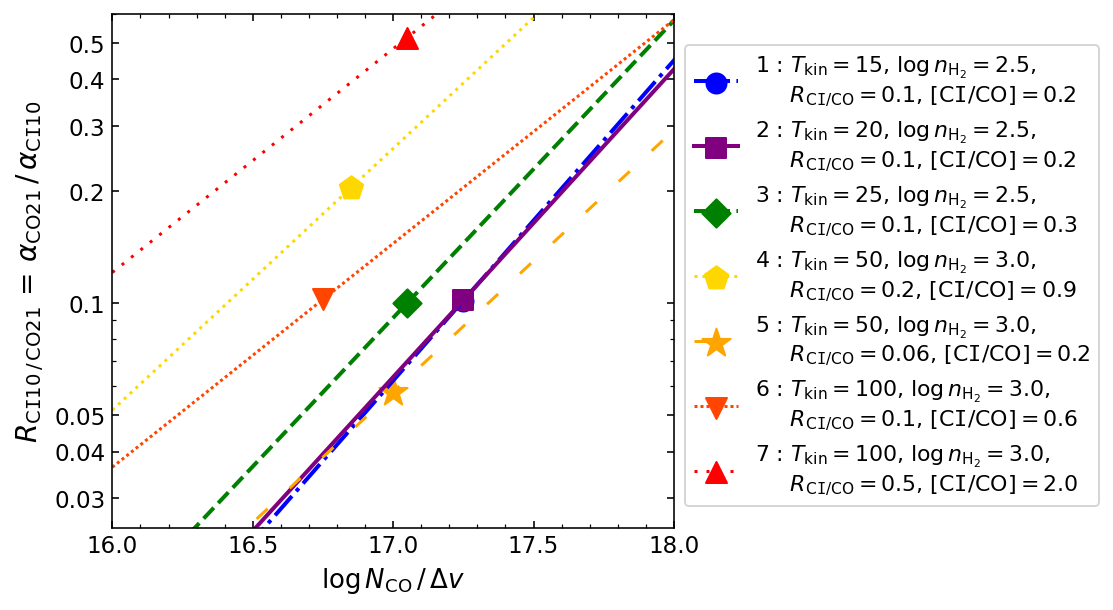

In [23]:
# Compute alphaCO alphaCI in a grid of N_CO_d_V then plot them
# Here we use inaccurate curve_fit of NLCorr

fig = plt.figure(figsize=(7.8, 4.2))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel(r'$\log N_{\mathrm{CO}} \, / \, {\Delta v}$')
ax.set_ylabel(r'$R_{\mathrm{C}{\tt{I}}10 \, / \, \mathrm{CO21}} \, = ' + \
              r'\, \alpha_{\mathrm{CO}21} \, / \, \alpha_{\mathrm{C}{\tt{I}}10}$', fontsize=14)
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))
ax.yaxis.set_major_locator(ticker.LogLocator(subs=(0.1, 0.2, 0.3, 0.4, 0.5, ), ))

grid_R_CI10CO21_calc = np.full([len(list_of_T_kin_for_N_repISM), len(grid_N_CO_d_V)], fill_value=np.nan)
grid_alphaCO10_calc = np.full([len(list_of_T_kin_for_N_repISM), len(grid_N_CO_d_V)], fill_value=np.nan)

for i in range(len(grid_N_CO_d_V)):
    
    N_CO_d_V = grid_N_CO_d_V[i]
    
    list_of_alphaCO10_for_N_repISM = np.array([
            (func_alphaCO10_T_NLCorr_curvefit(t1, N_CO_d_V, t4) * (1e-4) / (t5)) \
            for t1,t4,t5 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
            ))
        ])
    list_of_alphaCO21_for_N_repISM = np.array([
            (func_alphaCO21_T_NLCorr_curvefit(t1, N_CO_d_V, t4) * (1e-4) / (t5)) \
            for t1,t4,t5 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
            ))
        ])
    list_of_alphaCI10_for_N_repISM = np.array([
            (func_alphaCI10_T_NLCorr_curvefit(t1, t4) * (1e-4 * 0.2) / (t5 * t6)) \
            for t1,t4,t5,t6 in \
            list(zip(
                list_of_T_kin_for_N_repISM, 
                list_of_n_H2_for_N_repISM, 
                list_of_X_COH2_for_N_repISM, 
                list_of_X_CICO_for_N_repISM, 
            ))
        ])
    list_of_R_CI10CO21_calc = (\
            list_of_alphaCO21_for_N_repISM / \
            list_of_alphaCI10_for_N_repISM \
        )
    grid_R_CI10CO21_calc[:, i] = np.array(list_of_R_CI10CO21_calc)
    grid_alphaCO10_calc[:, i] = list_of_alphaCO10_for_N_repISM

plot_objects = []
plot_labels = []
for i in range(len(list_of_T_kin_for_N_repISM)):
    linestyle = list_of_linestyle_for_N_repISM[i]
    linethick = list_of_linethick_for_N_repISM[i]
    linecolor = list_of_linecolor_for_N_repISM[i]
    linelabel = list_of_linelabel_for_N_repISM[i]
    marker = list_of_marker_for_N_repISM[i]
    markersize = 100
    if marker == '*':
        markersize = int(markersize * 2.2)
    elif marker == 'p':
        markersize = int(markersize * 1.5)
    elif marker == 'v' or marker == '^':
        markersize = int(markersize * 1.1)
    if isinstance(linestyle, dict):
        linestyle = [linestyle[t] for t in linestyle][0]
    if linelabel is None or linelabel == '':
        linelabel = str((i+1)) + ' : ' + \
                    r'$T_{\mathrm{kin}} = ' + \
                    r'{:g}'.format(list_of_T_kin_for_N_repISM[i]) + \
                    r'$' + \
                    ', ' + \
                    r'$\log n_{\mathrm{H_2}} = ' + \
                    r'{:.1f}'.format(np.log10(list_of_n_H2_for_N_repISM[i])) + \
                    r'$' + \
                    ', \n     ' + \
                    r'$R_{\mathrm{C}{\tt{I}}/\mathrm{CO}} = ' + \
                    r'{:g}'.format(list_of_R_CI10CO21_for_N_repISM[i]) + \
                    r'$' + \
                    ', ' + \
                    r'$[\mathrm{C}{\tt{I}}/\mathrm{CO}] = ' + \
                    r'{:.1f}'.format(list_of_X_CICO_for_N_repISM[i]) + \
                    r'$'

    x = np.log10(grid_N_CO_d_V)
    y = grid_R_CI10CO21_calc[i, :]
    
    # find a point in the model line that matches the observed R_CI10CO21
    ix = np.nanargmin(np.abs(y - \
                             list_of_R_CI10CO21_for_N_repISM[i]))
    scatter_x = [np.log10(grid_N_CO_d_V[ix])]
    scatter_y = [grid_R_CI10CO21_calc[i, ix]]
    
    # plot the model line
    plot_obj1 = ax.plot(x, 
                y, 
                ls=linestyle, 
                lw=linethick, 
                color=linecolor, 
                label=linelabel, 
           )
    
    # plot the scatter points on the model lines that match the observed R_CI10CO21
    plot_obj2 = ax.scatter(scatter_x, 
                scatter_y, 
                marker = marker, 
                s = markersize, 
                color = linecolor, 
                label = '__none__'
            )
    
    ax.set_xlim([16.0, 18.0])
    ax.set_ylim([0.025, 0.6])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    
    plot_objects.append((plot_obj1[0], plot_obj2))
    plot_labels.append(linelabel)
    
    print('repISM {} : alphaCO10^NoHe = {:.2f} (w/He {:.2f}), NCO/Dv = {:.2e}'.format(
        i+1, grid_alphaCO10_calc[i, ix], 
        grid_alphaCO10_calc[i, ix] * 1.36, 
        grid_N_CO_d_V[ix]))

ax.legend(plot_objects, plot_labels, fontsize=11., loc='center left', bbox_to_anchor=(1.0, 0.0, 0.5, 0.98))
#fig.tight_layout()
fig.subplots_adjust(left=0.10, right=0.60, bottom=0.12, top=0.97)
fig.savefig(out_figure_name + '_curve_fit.pdf', dpi=300)
print('Output to {!r}'.format(out_figure_name + '_curve_fit.pdf'))
